In [52]:
class DataObjHistory:
    def __init__(self,init_data:dict):
        self._current_data = init_data.copy()
        self._current_rev = 0
        self.revisions = []

    def get_active_rev(self):
        return self._current_rev

    def get_active_data(self):
        return self._current_data

    def set_active_data(self,new_data):
        self.get_differencing(new_data)
        self._current_data = new_data.copy()
        self._current_rev+=1

    def add_key(self,key,value):
        self.update_key(key,value)

    def update_key(self,key,value):
        new_data = self._current_data.copy()
        new_data[key]=value
        self.set_active_data(new_data)

    def delete_key(self,key):
        new_data = self._current_data.copy()
        del new_data[key]
        self.set_active_data(new_data)

    def get_differencing(self,new_data):
        difference_dict = {'+':{},'-':{}}
        for key in self._current_data:
            difference_dict = self.difference_old_key(key,new_data,difference_dict)
            
        for key in new_data:
            difference_dict = self.difference_new_key(key,new_data,difference_dict)

        self.revisions.append(difference_dict)
        
    def difference_old_key(self,key,new_data,difference_dict):
        if key not in new_data:difference_dict['-'][key] = self._current_data[key]
        else: #if key in new_data
            if new_data[key]!=self._current_data[key]:
                difference_dict['-'][key] = self._current_data[key]; difference_dict['+'][key] = new_data[key]
        return difference_dict

    def difference_new_key(self,key,new_data,difference_dict):
        if key not in self._current_data:
            difference_dict['+'][key]=new_data[key]
        return difference_dict

    def get_old_data(self,revision_number):
        if revision_number>self._current_rev:raise IndexError("This revision number does not exist. Highest data revision is {}.".format(self._current_rev))
        if revision_number==self._current_rev:return self._current_data
        differencings = self.revisions[revision_number:self._current_rev]
        reconstructed_data = self._current_data.copy()
        for differencing in reversed(differencings):
            for key in differencing['+']: del reconstructed_data[key]
            for key in differencing['-']: reconstructed_data[key] = differencing['-'][key]

        return reconstructed_data

In [53]:
data_obj = {'x':0,'y':0}

data_history = DataObjHistory(data_obj)
data_history.add_key('z',0) # 1
data_history.update_key('x',1) # 2
data_history.delete_key('y') #3
data_history.update_key('z',{'z1':0,'z2':2j})
data_history.delete_key('z')

In [54]:
data_history.revisions

[{'+': {'z': 0}, '-': {}},
 {'+': {'x': 1}, '-': {'x': 0}},
 {'+': {}, '-': {'y': 0}},
 {'+': {'z': {'z1': 0, 'z2': 2j}}, '-': {'z': 0}},
 {'+': {}, '-': {'z': {'z1': 0, 'z2': 2j}}}]

In [55]:
for rev in range(data_history.get_active_rev()+1):
    print(f"Rev {rev}:{data_history.get_old_data(rev)}")

Rev 0:{'y': 0, 'x': 0}
Rev 1:{'z': 0, 'y': 0, 'x': 0}
Rev 2:{'x': 1, 'z': 0, 'y': 0}
Rev 3:{'x': 1, 'z': 0}
Rev 4:{'x': 1, 'z': {'z1': 0, 'z2': 2j}}
Rev 5:{'x': 1}


In [57]:
%%capture result
for i in range(data_history.get_active_rev()+1,0,-1):
    %timeit data_history.get_old_data(i-1)

In [58]:
print(list(range(data_history.get_active_rev()+1,0,-1)))

[6, 5, 4, 3, 2, 1]


In [59]:
print(result.stdout)
results = list(zip(range(1,data_history.get_active_rev()+2),map(lambda s:float(s[:s.find(" ns")]),result.stdout.split("\n")[:-1])))
results

50.9 ns +- 0.442 ns per loop (mean +- std. dev. of 7 runs, 10,000,000 loops each)
312 ns +- 1.29 ns per loop (mean +- std. dev. of 7 runs, 1,000,000 loops each)
440 ns +- 5.73 ns per loop (mean +- std. dev. of 7 runs, 1,000,000 loops each)
553 ns +- 4.59 ns per loop (mean +- std. dev. of 7 runs, 1,000,000 loops each)
718 ns +- 5.84 ns per loop (mean +- std. dev. of 7 runs, 1,000,000 loops each)
788 ns +- 7 ns per loop (mean +- std. dev. of 7 runs, 1,000,000 loops each)



[(1, 50.9), (2, 312.0), (3, 440.0), (4, 553.0), (5, 718.0), (6, 788.0)]

(1, 2, 3, 4, 5, 6) [50.9, 156.0, 146.66666666666666, 138.25, 143.6, 131.33333333333334]


Text(0, 0.5, 'Reconstruction nanoseconds per revision')

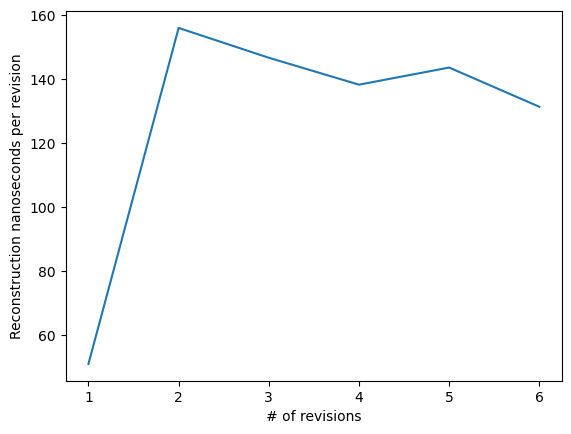

In [60]:
import matplotlib.pyplot as plt
x,y = zip(*results)
print(x,[y_/x_ for x_,y_ in results])
plt.plot(x,[y_/x_ for x_,y_ in results])
plt.xlabel('# of revisions')
plt.ylabel('Reconstruction nanoseconds per revision')

In [62]:
x_study = x[1:]
y_study = y[1:]
x_study,y_study

((2, 3, 4, 5, 6), (312.0, 440.0, 553.0, 718.0, 788.0))

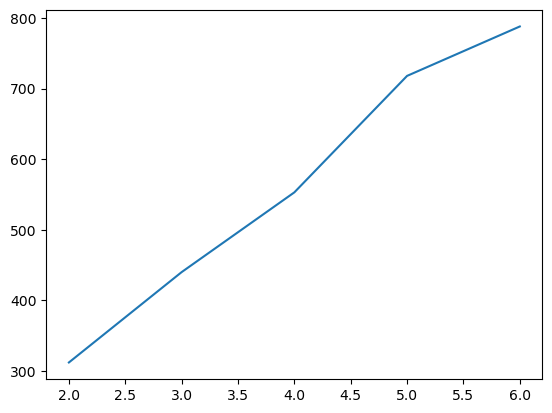

In [63]:
plt.plot(x_study,y_study) #looks roughly linear, O(n)

In [71]:
#let's test for good correlation of a simple linear relationship. obviously this is limited. ideally we'd go up to x = 1000, but in interest of time, we won't

#let's just do it naively to prove a simple point:
m = (y_study[-1]-y_study[0])/(x_study[-1]-x_study[0])
b = sum(y_study_-(m*x_study_) for x_study_,y_study_ in zip(x_study,y_study))/len(x_study)
y_hat = list(m*x_study_ + b for x_study_ in x_study)
perc_diffs = list((y_hat_-y_study_)/y_study_ for y_study_,y_hat_ in zip(y_study,y_hat))
list(perc_diff*100 for perc_diff in perc_diffs)


[3.9102564102564066,
 0.7272727272727246,
 1.6636528028933173,
 -5.1253481894150354,
 1.548223350253813]

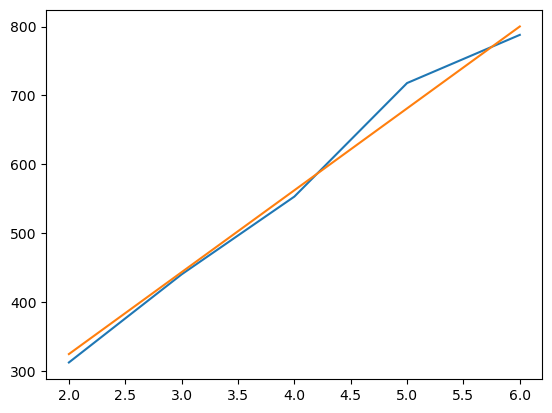

In [72]:
# pretty good, let's plot it
plt.plot(x_study,y_study)
plt.plot(x_study,y_hat)